# Leveraging sparsity for efficient data manipulation: the GCXS sparse array format

Across many areas of science, sparsity is ubiquitous. Whether in the form of sparse data arrays, sparse linear operators, or the results from a sparsity-promoting optimization, data in the form of sparse vectors, matrices, and tensors are commonplace in scientific computing. In this post, I will highlight the pydata/sparse package and the recently added GCXS sparse array format for working with large sparse data. For a more detailed demonstration of the GCXS sparse array format and operations, see the more technical section at the end of this post. 



## Quick introduction to sparse data

<img src="images/fsl_mean_img.png" align="left"/> 
<img src="images/fsl_empty.png" align="right"/>

Neuroimaging data is an interesting test case. MRI data is collected in a 3-dimensional grid and is often transformed into a standard space with specific dimensions. One standard, the Montreal Neurological Institute space (MNI152), has the dimensions (91, 109, 91). A brain in this space, however,  typically occupies only a third of the full space, with the remainder of the array filled with zeros.

When working with more dimensions like time or research subjects, these datasets can get quite large and be computationally expensive. Shown above on the left is an averaged fractional anisotropy (FA) image. The image on the right illustrates all of the remaining space, which is generally filled with zeros.

identity (99% sparse) | symmetric (99% sparse) | random (99% sparse) 
- | - | -
![](images/eye_matrix.png) | ![](images/symmetric_matrix.png) | ![](images/random.png) 



Sparse data structures, by definition, consist mostly of the same repeated value, typically zero. In the three matricies shown above, only 1% of the entries have a nonzero value. This feature can be exploited so as to reduce storage and runtime; sparse data is highly compressible because we can get away with only storing the nonzero values. 

There are many ways to store the nonzeros of a sparse data structure, which are manifested in sparse storage formats and are efficient for certain operations. For example, a hashmap is well-suited for storing pairs of indices and their corresponding nonzero values and allows for efficient writing and mutating, but is poorly-suited for mathematical operations. By contrast, the compressed sparse row (CSR) storage format is well-suited for fast mathematical operations and compresses nicely but offers extremely inefficient writing and mutating capabilities. 

There are many widely-used sparse matrix storage formats, many of which, however, do not generalize well to higher dimensional arrays. Some are listed below:

 - dictionary of keys (DOK)
 - compressed sparse column (CSC)
 - compressed sparse row (CSR)
 - coordinate list (COO)
 - list of lists (LIL)
 - block compressed sparse row (BSR)

## Can we just use `scipy.sparse`?

In the scientific Python ecosystem, scipy.sparse has long been the center piece of all sparse computation. It includes:

  - all of the above sparse matrix formats
  - sparse linear system solvers (both direct and iterative)
  - sparse eigen solvers (including support for the singular value decomposition)

Additionaly, libraries that utilize sparse data such as scikit-learn rely on scipy.sparse. While being a mature and fast codebase, scipy.sparse emulates the numpy.matrix interface, which is restricted to two dimensions and is pending deprecation. As a result, scipy.sparse doesn't work well in places that numpy.ndarray does.  It also doesn't play nicely with the many libraries that emulate the numpy.ndarray interface such as Dask and Xarray. 

Because some of these libraries play important roles in scaling out the scientific Python ecosystem to larger data and distributed computing platforms, the reliance on the numpy.matrix interface is holding scipy.sparse back.





> scipy.sparse doesn't work well in places that numpy.ndarray does

## `pydata/sparse` aims to be the solution

In efforts to address the concerns of scipy.sparse, the pydata/sparse library implements n-dimensional sparse data structures that emulate the numpy.ndarray interface. Pydata/sparse does this by extending two sparse matrix formats and supporting common NumPy operations: 
   - extends DOK for writing (uses a hashmap)
   - extends COO for computing (uses NumPy arrays to store coordinates and nonzero values)
   - element-wise operations
   - reductions
   - np.dot and dot-related operations
   - compatible with Xarray and Dask

The COO format, while fundamental, has several shortcomings in the way of compression and interoperability with the current users. Regarding compression, because COO stores a coordinate for each dimension of an array along with the nonzeros, as the number of dimensions increases, the storage requirements can quickly become unfavorable (O(ndim * nnz)). Also, most of the functions written inside scikit-learn and elsewhere work with compressed sparse row/column (CSR/CSC) matrices, not COO.


## GCXS format addresses shortcomings

With these issues in mind, pydata/sparse recently released the GCXS format, inspired by the GCRS/GCCS formats of [Shaikh and Hasan 2015](https://ieeexplore.ieee.org/document/7237032/authors#authors). 

GCXS is an n-dimensional generalization of CSR/CSC. A main feature is that 2-D GCXS arrays are identical to CSR/CSC matrices (depending on which axis is compressed). This makes it so that libraries that use the CSR/CSC model internally, like scikit-learn, can easily be modified to work with GCXS arrays. GCXS is also capable of a high degree of compression.

#### *Returning to neuroimagining data...*

Because the neuroimaging data exceeds two dimensions, we can't use scipy.sparse. When the density of an array grows too high, sparse array formats become less and less beneficial. Data with such high density (0.33) pushes the limits of what is useful for most sparse array formats. 

Let's import what we need and see how well we can do.

In [1]:
import warnings
warnings.filterwarnings('ignore')

import sparse
import numpy
import pandas
import nibabel
import scipy.sparse
import nilearn.plotting

 Here is a dataset with sixteen subjects:

In [2]:
img = nibabel.load('FA_data.nii.gz')

As a quick data check, let's have a look at the fractional anisotropy (FA) values of our first subjects' brain.

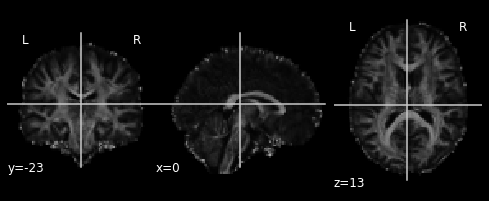

In [3]:
nilearn.plotting.plot_anat(img.slicer[...,0])

In [4]:
data = sparse._compressed.GCXS.from_numpy(img.get_data(), compressed_axes=[3], idx_dtype=numpy.int32)
data

Format,gcxs
Data Type,float64
Shape,"(91, 109, 91, 16)"
nnz,4597231
Density,0.31832229797624495
Read-only,True
Size,52.6M
Storage ratio,0.5
Compressed Axes,"(3,)"


Looking at the storage ratio (0.5), we can see the storage requirements of this GCXS array are 50% of the resources required to store this same data in a numpy.ndarray. So even with the high density (.318) we are able to get substantial compression with GCXS. Because of the high density and the high number of dimensions, COO is much less well-suited to store this data. 

In [5]:
data.tocoo()

Format,coo
Data Type,float64
Shape,"(91, 109, 91, 16)"
nnz,4597231
Density,0.31832229797624495
Read-only,True
Size,105.2M
Storage ratio,1.0


With a storage ratio of 1.0, using COO requires us to use 100% of the storage requirements of a numpy.ndarray with this same data. This means that we are not seeing any compression benefits from using COO to store this data.

One common need in a diffusion-weighted imaging analysis is to separate the white matter from the gray matter. The goal is to define a white matter mask that we can use on all of our subjects. 

One simple way to do this is to take the mean across subjects and threshold the data. When we are working with fractional anisotropy values (FA), the white matter and gray matter are naturally separated by higher values in the white matter. Because we are interested in computing across subjects, we can compress the subjects' dimension and group all of the spatial dimensions together. 

Just like if this were a NumPy array, we can take the mean along the third axis, corresponding to subjects:

In [6]:
mean = data.mean(axis=3)

Since we took the mean across the subjects dimension, we have an array that is the size of a brain and that holds the average value for each voxel:

In [7]:
mean.shape

(91, 109, 91)

We can pass this array to Nibabel to create an image file and plot that image:

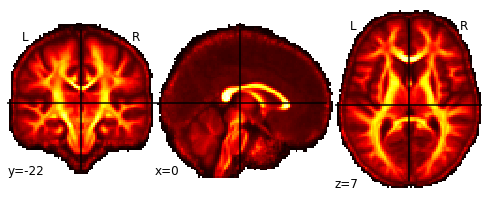

In [8]:
header = img.header # use previous image header
header['cal_min'] = mean.min() # update min and max
header['cal_max'] = mean.max()
mean_dense = mean.todense() # nibabel expects a NumPy array so we'll convert to dense
mean_img = nibabel.Nifti1Image(mean_dense, header=header, affine=img.affine)
nilearn.plotting.plot_stat_map(mean_img, colorbar=False)

The white matter comes out very bright. We can threshold the data to fully separate the white matter from the gray. In the plot below, the plotting function provides an empty gray brain to plot over. Parts that are gray have a value of zero.

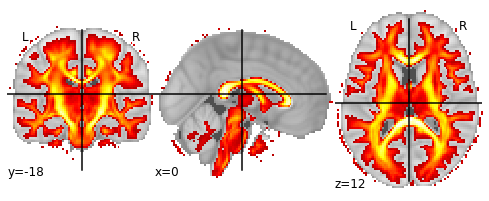

In [9]:
mean_dense[mean_dense < .2] = 0 #threshold by setting values below 0.2 to 0
mean_img = nibabel.Nifti1Image(mean_dense, header=header, affine=img.affine)
nilearn.plotting.plot_stat_map(mean_img, colorbar=False)

#### *What just happened?*

In this short demonstration we were able to use Sparse arrays instead of NumPy arrays without needing to learn a different interface, since Sparse copies the NumPy interface. Instead of computing the mean across every measurement we were able to compute over only the necessary measurements, while using only 60% of the memory required by NumPy.

## How about SVD?

Pydata/sparse is primarily focused on providing sparse array objects. The objects are compatible with the algorithms in scipy.sparse, which include direct and iterative sparse linear system solvers and iterative eigen solvers. 

The singular value decomposition is a critical procedure for a lot of data analytics applications. Using sparse arrays alongside Scipy makes this procedure feel natural. Similar to generating "eigen faces," with the SVD we can look at the low-rank structure of our data and visualize the columns of U by projecting them onto a brain, possibly to denoise the data or examine structure, but mostly for fun.

The singular value decomposition requires that we fold the sparse data into a new shape. Otherwise we raise an error.

In [10]:
try: scipy.sparse.linalg.svds(data, 15)
except ValueError: ...

The matrix that we want to decompose will have voxels-by-subjects dimensions (902629, 16). The singular value decomposition of this matrix will tell about spatial patterns that emerge (the U matrix) and the patterns across subjects (the VT matrix). Since our GCXS array already implicitly stores the data as a sparse matrix with the dimensions (16, 902629), we can flip these values and tell the constructor that we're using compressed_axes=(1,).  

A singular value decomposition can now operate on the folded 2-D form.

In [11]:
folded = sparse._compressed.GCXS(
        (data.data, data.indices, data.indptr),
        shape=data._compressed_shape[::-1], 
        compressed_axes=[1])

U, S, VT = scipy.sparse.linalg.svds(folded, 15)

The columns of U hold the dominant spatial patterns of the data. We can reshape these vectors and project them onto brains:

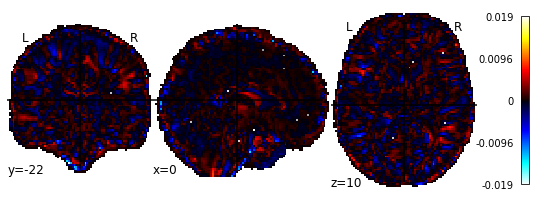

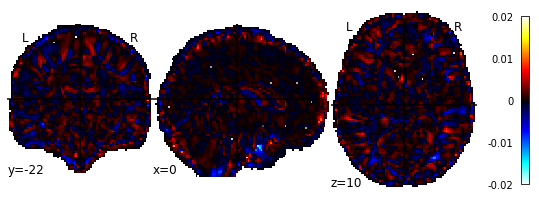

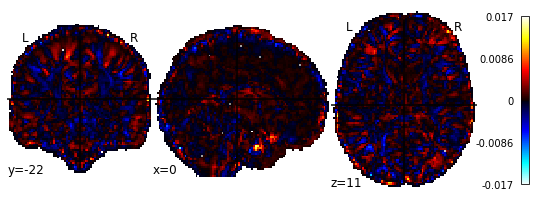

In [12]:
for i in range(3):
    image = U[:,i].reshape((91,109,91)) # reshape the columns of U to MNI dimensions
    header['cal_min'], header['cal_max'] = image.min(), image.max() # update header
    brain = nibabel.Nifti1Image(image, header=header, affine=img.affine)
    nilearn.plotting.plot_stat_map(brain)

#### *What just happened?*

Pydata/sparse data structures have access to the fast linear algebra routines inside scipy.sparse. Without switching data structures, we were able to quickly apply a singular value decomposition to our data. We can understand the FA data of our subjects brains in terms of a low-rank structure made up from linear combinations of the brains we see plotted above. While these spatial modes are not readily interpretable, we can see that there is a high degree of structure in each image, with each emphasing certain features of the white and gray matter.  

# Conclusion

Problems involving sparsity are pervasive in scientific computing. Efficiently storing and manipulating large sparse arrays requires thoughtful storage formats. In an ecosystem where more and more libraries emulate and interact with NumPy, it's important that sparse arrays be compatable, especially with libraries like Dask, for predictablity of behavior and scalability. Pydata/sparse arrays offer these features. 

Each storage format offers different advantages. Because GCXS is identical to CSR/CSC for two-dimensional arrays, it is primed to work effectively in all of the libraries that expect CSR/CSC. It also excels in the same areas as CSR/CSC; namely in fast matrix multiplication. Above and beyond this, GCXS offers good compression for storage of high-dimensional arrays.

# A Closer Look at GCXS Operations

Understanding how GCXS works requires first understanding how the CSR/CSC model works for matrices. For a CSR matrix, we store three arrays: the nonzero data, the indices corresponding the columns of each of the each the nonzero data, and an array of integers that point to where each row begins in the indices array.


## Matrix indexing

Here we make a 5x5 CSR matrix

In [13]:
a = sparse.random((5,5), density=.2, format='gcxs')

In [14]:
a

Format,gcxs
Data Type,float64
Shape,"(5, 5)"
nnz,5
Density,0.2
Read-only,True
Size,51
Storage ratio,0.3
Compressed Axes,"(0,)"


In [15]:
a.todense()

array([[0.        , 0.        , 0.        , 0.        , 0.64334836],
       [0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.31703489, 0.        , 0.        , 0.46506029, 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.74588844, 0.52182962, 0.        , 0.        ]])

As we can see, the data is sorted in row-major ordering:

In [16]:
a.data

array([0.64334836, 0.31703489, 0.46506029, 0.74588844, 0.52182962])

The indices store which columns have nonzeros:

In [17]:
a.indices

array([4, 0, 3, 1, 2], dtype=uint8)

The index pointer array tells us how many nonzero values there are in each row. For example, if we want to know how many nonzero values there are in the third row, we subtract the fourth value from the third value of indptr: 

In [18]:
a.indptr, a.indptr[3] - a.indptr[2]

(array([0, 1, 1, 3, 3, 5], dtype=uint8), 2)

The columns stored in 'indices' for the i-th row correspond to a.indices[a.indptr[i]:a.indptr[i+1]]

In [19]:
for i in range(5):
    print(f"The nonzero columns of row {i} ", a.indices[a.indptr[i]:a.indptr[i+1]])

The nonzero columns of row 0  [4]
The nonzero columns of row 1  []
The nonzero columns of row 2  [0 3]
The nonzero columns of row 3  []
The nonzero columns of row 4  [1 2]


The CSC data structure uses the same idea but stores the data in column-major ordering:

In [20]:
b = a.change_compressed_axes([1])
b

Format,gcxs
Data Type,float64
Shape,"(5, 5)"
nnz,5
Density,0.2
Read-only,True
Size,51
Storage ratio,0.3
Compressed Axes,"(1,)"


In [21]:
b.todense()

array([[0.        , 0.        , 0.        , 0.        , 0.64334836],
       [0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.31703489, 0.        , 0.        , 0.46506029, 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.74588844, 0.52182962, 0.        , 0.        ]])

Now the data is sorted in column-major form:

In [22]:
b.data

array([0.31703489, 0.74588844, 0.52182962, 0.46506029, 0.64334836])

The 'indices' array now stores the rows of the nonzero values:

In [23]:
b.indices

array([2, 4, 4, 2, 0], dtype=uint8)

And now the index pointer array tells us which of the rows in 'indices' correspond to what column:

In [24]:
b.indptr

array([0, 1, 2, 3, 4, 5], dtype=uint8)

In [25]:
for i in range(5):
    print(f"The nonzero rows of column {i} ", b.indices[b.indptr[i]:b.indptr[i+1]])

The nonzero rows of column 0  [2]
The nonzero rows of column 1  [4]
The nonzero rows of column 2  [4]
The nonzero rows of column 3  [2]
The nonzero rows of column 4  [0]


For GCXS, CSR and CSC can be thought of as the same data structure, but with a different compressed axis. For CSR the first axis (rows) are compressed whereas for CSC the second axis (columns) are compressed.

In [26]:
a.compressed_axes

(0,)

In [27]:
b.compressed_axes

(1,)

## Transposing and reshaping

The way we can work with arrays of higher dimensions using this kind of scheme is by transposing axes and reshaping the original array into a two-dimensional array and applying the same methods. We transpose the axes to put the compressed axes first and the reshape the array to two dimensions with the resulting shape: (product of compressed axes, product of uncompressed axes). For a 3x4x5 array, if we compress the first axis then we will store a CSR matrix with a shape of (3, 4x5=20).

In [28]:
x = sparse.random((3,4,5), density=.2, format='gcxs')

In [29]:
x._compressed_shape

(3, 20)

If we compress the second axis, then we transpose the array and reshape it into a (4, 3x5=15) matrix.

In [30]:
x.change_compressed_axes([1])._compressed_shape

(4, 15)

We can also compress multiple axes:

In [31]:
x.change_compressed_axes([0,2])._compressed_shape

(15, 4)

Different choices in compressed axes affects the degree of compression and the speed of certain operations, especially indexing. Like CSR/CSC, the storage demands are determined by the size of the compressed axes and the number of nonzeros. 

Because the storage demands of a GCXS array are not dependent on the number of dimensions of the array, GCXS compresses well even with high dimensional arrays. The best compression is achieved by compressing the smallest axis.  

Let's several compression options and see how well they work:

In [32]:
y = sparse.random((5,20,35,50), density=.15, format='gcxs', idx_dtype=numpy.int32)
axes = ([0], [1], [2], [3], [0,1], 
        [0,2], [0,3], [1,2], 
        [1,3], [2,3], [0,1,2],
        [0,2,3], [1,2,3])
percent_stored = []
shapes = []
for axis in axes:
    y = y.change_compressed_axes(axis)
    percent_stored.append(y.nbytes/(numpy.prod(y.shape)*y.dtype.itemsize) *100)
    shapes.append(y._compressed_shape)
df = pandas.DataFrame()
df['compressed_axes'] = axes
df['percent_compression'] = percent_stored
df['compressed_shape'] = shapes
df

,compressed_axes,percent_compression,compressed_shape
0,[0],22.501714,"(5, 35000)"
1,[1],22.506000,"(20, 8750)"
2,[2],22.510286,"(35, 5000)"
3,[3],22.514571,"(50, 3500)"
4,"[0, 1]",22.528857,"(100, 1750)"
5,"[0, 2]",22.550286,"(175, 1000)"
6,"[0, 3]",22.571714,"(250, 700)"
7,"[1, 2]",22.700286,"(700, 250)"
8,"[1, 3]",22.786000,"(1000, 175)"
9,"[2, 3]",23.000286,"(1750, 100)"


As we can see, compressing the three largest axes together gets the worst compression. Nonetheless, in this example the worst compression still results in storing only half of the bytes needed for the equivelant dense array. Also, with this number of dimensions, the compression will usually be much better than COO:

In [33]:
y.tocoo().nbytes/(numpy.prod(y.shape)*y.dtype.itemsize) *100

45.0

GCXS arrays compress well and look and behave like NumPy arrays. GCXS currently supports the following operations:
 - indexing
 - multiplication
     - dot
     - tensordot
     - matmul
 - element-wise operations
     - np.sin
     - np.sqrt
     - np.add
     - np.log
     - etc.
 - reductions
     - min
     - max
     - sum
     - prod
     - mean
     - std
     - var
     - etc.